Final Project Check-in 2018-11-16
------

Group Name
-----
Data Explorers

Student Names
----

1. Adam Reevesman
2. Gokul Krishna
3. Hai Le
4. Maximillian Alfaro 
5. Prakhar Agrawal:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pathlib import Path
import re
import seaborn as sns
from scipy.sparse import hstack
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Load Data
-----

In [2]:
path = Path('Data/')
df = pd.read_feather('Data/May2015_subset.fthr')

/anaconda3/envs/ml/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [3]:
df.tail(3).T

,6195169,6195170,6195171
created_utc,1433116781,1433116784,1433116785
ups,170,9,37
subreddit_id,t5_2qh13,t5_2qh13,t5_2qh13
link_id,t3_37zl5z,t3_380j06,t3_37z0mw
name,t1_crrbedn,t1_crrbefm,t1_crrbeft
score_hidden,0,0,0
author_flair_css_class,None,None,None
author_flair_text,None,None,None
subreddit,worldnews,worldnews,worldnews
id,crrbedn,crrbefm,crrbeft


Preprocessing and Feature Engineering
-----

First is to exclude columns that are not helpful.

In [4]:
excluded_var = ['subreddit_id', 'score_hidden', 'author_flair_css_class', 
                'author_flair_text', 'removal_reason', 'gilded', 'downs', 'archived', 
                'author', 'retrieved_on', 'edited']
df = df.drop(excluded_var, axis=1)

In [5]:
df['subreddit'] = df.subreddit.astype('category')
# fill na in `distinguised` with 0
df['distinguished'].fillna('None', inplace=True)
df['distinguished'] = df.distinguished.astype('category')
df['link_id'] = df.link_id.astype('category')

And make sure the data is in the format we want, eg. for time data to be in datetime format.

In [6]:
# Convert into date-time type
df['time'] = pd.to_datetime(df.created_utc, unit='s')

Remove outliers: the target variable we want to predict is the `score` of the comment. By checking the distribution plot of this variable, we've identified that most comments have scores in the range from -20 to 20. There are, however, a number of comments that scored as high as almost 6000. To avoid noise, we will remove comments that scored below -20 and above 20.

In [7]:
df = df[(df['score'] <= 20) & (df['score'] >= -20)]

Then we create features based on the raw data we have.

In [8]:
# Compute the time lapse of each comment compared with the first one
df_first_comment = df[['link_id', 'time']].groupby(by=['link_id']).min()
df_first_comment_dict = df_first_comment.to_dict('index')

def time_zero(x):
    return df_first_comment_dict[x]['time']

df['time_lapse'] = df.time - df.link_id.apply(time_zero)

df['time_lapse'] = df.time_lapse.apply(lambda x: x.seconds)  # convert into seconds

In [9]:
# Compute the depth of the comment in the thread
def pd_to_dict(df, index='', column=''):
    dft = df.copy(deep=True)
    dft.index = dft[index]
    dft = dft.drop([index], axis=1)
    res = dft.to_dict()[column]
    del dft
    return res

comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return np.nan
        counter += 1
        
df['depth'] = df['name'].apply(get_depth)

A fraction of records doesn't have a proper `parent_id` which results in nulls in our derived feature `depth`. So we will remove those rows.

In [10]:
df = df[df.depth.isna() == False]

Now we can also get rid of unuseful records, ie. those whose comment text was deleted.

In [11]:
df = df[~(df.body == '[deleted]')]

In [12]:
# Comment types: response to other comments or to links
df['respond_to_comment']=np.where(df['parent_id'].str.startswith('t1'), 1,0)
df['respond_to_link']=np.where(df['parent_id'].str.startswith('t3'),1,0)

In [13]:
# Subjectivity of the comments
df['subjectivity'] = df['body'].str.count('i ')

In [14]:
# word count 
df['body'] = df['body'].str.replace('[.,?!;:]', '')  # remove punctuations
df['word_count'] = df['body'].str.split().str.len()

# remove comments that have  more than 300 words (outliers)
df = df[df['word_count'] < 300]

In [15]:
# word count categorical variable
bins=[-1, 25, 50, 100, 300]
df['word_count_cat'] = pd.cut(df['word_count'], 
                                  bins, labels=['short', 'medium', 'long', 'very long'])

In [16]:
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))

In [17]:
df['weekday'] = df['time'].dt.dayofweek
df['weekday'] = df.weekday.astype('category')

Fit scikit-learn model
----

Now that we have the features we want, we can drop original features that are no longer needed for model fitting.

In [18]:
drop_variables = ['created_utc', 'ups', 'link_id', 'name', 'id',
       'parent_id', 'time', 'linked_sr']

In [19]:
df = df.drop(drop_variables, axis=1)

In [20]:
df.tail(3).T

,6195164,6195168,6195170
subreddit,worldnews,worldnews,worldnews
score,2,1,9
body,No clue why this comment is being downvoted,Pretty sure they don't just behead people outr...,&gt Nothing they are doing is illegal under in...
distinguished,None,None,None
controversiality,0,0,0
time_lapse,83442,24915,1786
depth,5,2,2
respond_to_comment,1,1,1
respond_to_link,0,0,0
subjectivity,0,0,0


**Numeric predictors:**

`ups`, `time_lapse`, `depth`, `subjectivity`, `word_count`, `no_of_linked_sr` 
       

**Categorical predictors:**
* Those that do not need encoding: `controversiality`, `respond_to_comment`, `respond_to_link`
* Those that do: `weekday`, `word_count_cat`, `subreddit`, `distinguished`

**Text-based data:** `body` which is the text of the comment. We will encode it using a Tf-idf vectorizer.

In [21]:
cate_variables = ['weekday', 'word_count_cat', 'subreddit', 'distinguished']
X_non_text = pd.get_dummies(df, columns=cate_variables).drop(['body', 'score'], axis=1)

In [22]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['body'])

In [25]:
Y = df['score'].values
X = hstack([X_tfidf, X_non_text])

In [26]:
assert X.shape[0] == df.shape[0]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,
                                                    random_state=3)

In [28]:
lm_model = LinearRegression()
lm_model.fit(X_train, y_train)
y_predicted = lm_model.predict(X_test)

Evaluation Metric
----

In [29]:
mse = mean_squared_error(y_test, y_predicted)
print(mse)

9.973405975368358


In [41]:
mean_absolute_error(y_pred=y_predicted, y_true=y_test)

1.8333328095053314

In [42]:
r2 = r2_score(y_test, y_predicted)
print(f"{r2:.4}")

0.0599


[(-20, 20), Text(0.5, 0, 'Predicted scores')]

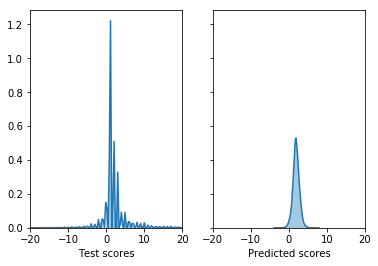

In [39]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True)

sns.distplot(y_test, ax=ax0)
ax0.set(xlabel='Test scores', xlim=(-20,20))

sns.distplot(y_predicted, ax=ax1)
ax1.set(xlabel="Predicted scores", xlim=(-20,20))